In [1]:
# Use this cell to regroup all your imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn import set_config; set_config(display='diagram')

In [2]:
# Use this cell to regroup all your imports

# 🏆 Le Wagon Kaggle Batch Challenge

<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>

🏆 Welcome to your first Kaggle competition!

The objective is to **submit online an answer** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


- We will start off with a **baseline model**
- After we will improve & refine our models
- We will approach the problem through **pipelines** (the best practice to take!)

A word on Kaggle:
- Kaggle will rank my submission amongst all participants!
- Everyone is publicly removed from the leaderboard after 2 months
- You can make to 10 submissions per day

🧹 Today is the perfect day to practice keeping your long notebook **tidy** 🧹
- "Collapse all headings" from the "command palette" (Cmd + Shift + P)
- Stay idempotent (restart & run all should never crash)
- Name and delete variables carefully

## Setup Kaggle

👉 Create an account on Kaggle if you want to participate in the competition. 

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

**Your whole class will compete as a group against the team of TAs**

## Load

We have already downloaded for you everything from Kaggle into your current notebook folder:
- `train.csv` is your (1460 * 81) training set containing `X` and `y`
- `test.csv` is your (1459 * 80) testing set without the associated target `y` 😈
- `sample_submission.csv` describing the format required to submit your answer
- `data_description.txt` describing all columns

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your test_score & ranking

❓ Load the train dataset in a DataFrame `data` and create your `X` and `y`. Inspect their shape

In [3]:
# You can use this direct download link if you don't want to create a Kaggle account
data = pd.read_csv("data/train.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
X = data.drop(columns=["SalePrice", "Id"])
y = data.SalePrice

In [5]:
X.shape

(1460, 79)

# 🐣 1. BASELINE

## 1.1 Initial feature overview

80 features is too much to deal with one-by-one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [6]:
X.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

❓ Store the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total ?

In [7]:
feat_categorical_nunique = [X[col].nunique() for col in X.columns if X[col].dtypes == "O"]

In [8]:
np.sum(feat_categorical_nunique)

252

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and spare, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with ~50 features max (📚 Read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

We know 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

❓ Plot the **histogram** of number of unique value per categorical feature. Do you see some quick wins?

<AxesSubplot:ylabel='Count'>

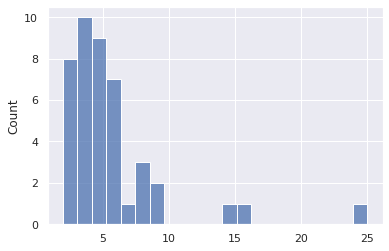

In [9]:
sns.histplot(feat_categorical_nunique)

💡 As a starter, what about simply **removing** all features that have **7 unique values or more**, and one-hot-encode every others? Let's keep ordinal encoding and statistical feature selection for the next iteration of our pipeline.

❓ Store features names to OHE in a list `feat_categorical_small` below. How many features will be OHE?

In [10]:
# categorical features to one-hot-encode
feat_categorical_small = [num for num in feat_categorical_nunique if num<7]

In [11]:
len(feat_categorical_small)

34

🧪 Test your code below (and clear the cell once it passed)

In [12]:
from nbresult import ChallengeResult
result = ChallengeResult('features_overview',
    n=len(feat_categorical_small))
result.write(); print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /home/idriss/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/idriss/code/OzRuby/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 1 item

tests/test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master


## 1.2 Baseline pipe

### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


As for numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 


<details>
    <summary>ℹ️ Pro tips</summary>

If you are confident, you can try sklearn's shorter syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax `Pipeline` or `ColumnTransformer` if you want to avoid giving names manually to every steps.
</details>

In [13]:
columns_light = [col for col in X.columns if (X[col].dtypes == "O" and X[col].nunique()<7) \
                 or X[col].dtypes != "O"]


In [14]:
X.MiscVal.dtypes == "int64"

True

In [15]:
len(columns_light)

70

In [16]:
X_light = X[columns_light]
X_light.shape

(1460, 70)

In [17]:
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.compose import make_column_transformer, make_column_selector , ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import  make_scorer,mean_squared_error 
from sklearn.model_selection import cross_validate , cross_val_predict, cross_val_score

In [18]:
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"), \
                         OneHotEncoder(handle_unknown="ignore", sparse=False))
cat_columns = make_column_selector(dtype_include=['object'])

In [19]:
num_pipe = make_pipeline(SimpleImputer(strategy="mean"),MinMaxScaler())
num_columns = make_column_selector(dtype_exclude=['object'])

In [20]:
preproc_baseline = make_column_transformer((cat_pipe, cat_columns), (num_pipe,num_columns))

In [21]:
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbdb0bc10>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbdb0bcd0>)])

In [22]:
data_preproc = preproc_baseline.fit_transform(X_light,y)

❓ Look at the **shape** of your preprocessed dataframe.

In [23]:
shape_preproc_baseline = data_preproc.shape

In [24]:
type(data_preproc)

numpy.ndarray

In [25]:
shape_preproc_baseline

(1460, 183)

🧪 Test your code below

In [26]:
from nbresult import ChallengeResult
result = ChallengeResult('preproc_baseline',
    shape=shape_preproc_baseline)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /home/idriss/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/idriss/code/OzRuby/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 1 item

tests/test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED   [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master


### b) Add estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [27]:
pipe_baseline = make_pipeline(preproc_baseline, Ridge())

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 
- Which performance metric do you need? Is it readily available in sklearn?
- We will need to create our custom `sklearn.metrics.scorer` object so as to pass to any cross-validation or grid search as below


👉 Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` kwarg as below:
```python
cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
```
👉 Create also the negative version `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` always tries to _maximize_ a score
```python
GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmse_neg)
```

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [28]:
def log_loss(y, y_pred):
    return ((np.log(y+1) - np.log(y_pred+1))**2).mean()**0.5

In [29]:
def rmse(y,y_pred):
    return mean_squared_error(y,y_pred)**0.5

In [30]:
len(X.MasVnrArea)

1460

In [31]:
rmsle = make_scorer(log_loss, greater_is_better=True)

In [32]:
rmse_scorer = make_scorer(rmse)

In [33]:
def log_loss_neg(y, y_pred):
    return -log_loss(y,y_pred)

❓5-fold cross_validate your `pipe_baseline` using this metric to get a first glance at your baseline perf.    

Store your mean score as `score_baseline`

In [34]:
cv_result = cross_validate(pipe_baseline, X_light, y , scoring=rmsle, cv=5)

In [35]:
cv_result

{'fit_time': array([0.0821135 , 0.13466001, 0.09954357, 0.10901475, 0.11926889]),
 'score_time': array([0.01593924, 0.03031874, 0.01418757, 0.0291326 , 0.01558208]),
 'test_score': array([0.16544312, 0.16837325, 0.1723072 , 0.16444757, 0.16157424])}

In [36]:
score_baseline = cv_result["test_score"].mean()

In [37]:
score_baseline

0.16642907520861652

In [38]:
cv_result["test_score"].mean()

0.16642907520861652

### d) Predict baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [39]:
pipe_baseline.fit(X_light, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbdb0bc10>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbdb0bcd0>)])),
                ('ridge', Ridge())])

In [40]:
X_test = pd.read_csv("data/test.csv")

In [41]:
X_test_light = X_test.drop(columns=["Id"])[columns_light].copy()

In [42]:
y_pred_baseline = pipe_baseline.predict(X_test_light)

❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. Read carefully the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [43]:
pd.DataFrame({"Id" : X_test.loc[:,"Id"], "SalePrice":y_pred_baseline}).to_csv("data/submission_baseline.csv", index=False)


In [44]:
y_pred_baseline

array([113256.76959388, 136811.0145436 , 174901.68834287, ...,
       157216.07718185, 111472.49591662, 234985.99120322])

🧪 Test your code

In [45]:
from nbresult import ChallengeResult
tmp = pd.read_csv("data/submission_baseline.csv")
result = ChallengeResult('submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /home/idriss/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/idriss/code/OzRuby/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 4 items

tests/test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.07s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline step'

git push ori

# 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation for having fully pipelined a basline model! You will see now how easier it is to iterate and improve performance 🚀

- Your goal is to improve your prediction and submit it by **16h30 max online**
- We suggested you some improvements below: **Pick up your fights** and **incrementally** improve your pipeline as you see fit

**Estimators**

- **Tree-based ensembles (must try today)**: Probably the best suited for many categorical-features problems
- Stacking !
- XGBoost !

**Preprocessing** (once your first ensemble models works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict log(SalePrice) instead?
- ...

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [47]:
cls = RandomForestRegressor(n_jobs=-1)
pipe_rfr = make_pipeline(preproc_baseline, cls)

In [48]:
cross_validate(pipe_rfr, X_light, y, scoring=rmsle)["test_score"].mean()

0.1459601474123743

In [49]:
pipe_rfr.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbdb0bc10>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                  

In [50]:
param_grid={
    #"randomforestregressor__max_depth":[3,4,5],
    "randomforestregressor__min_samples_split" : [2,3,4,5]  
}

search = GridSearchCV(pipe_rfr, param_grid=param_grid, scoring=rmsle, cv=5)

In [51]:
search.fit(X_light,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbdb0bc10>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbdb0bcd0>)])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=-1))]),
             param_grid={'randomforestregressor__min_samples_split': [2, 3, 4,
                                                                      5]},
             scoring=make_scorer(log_loss))

In [52]:
search.best_params_

{'randomforestregressor__min_samples_split': 3}

In [53]:
search.best_score_

0.1471142519146318

In [54]:
search.best_estimator_.fit(X_light,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbd233fa0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbd233220>)])),
                ('randomforestregressor',
                 RandomForestRegressor(min_samples_split=3, n_jobs=-1))])

In [55]:
search.best_estimator_.predict(X_test_light)

array([129709.80595238, 153575.03690476, 182595.20333333, ...,
       150932.6232381 , 117542.9847619 , 225543.504     ])

## 2.1 Preprocessing Iteration ♲ 
(**⚠️ come back here only after you have iterated on your estimators on section 2.2)**

⏩ Collapse me if you don't use me!

### a) Ordinal Encoding (1h)

❓ Look at the following feature below. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that. Check it out below and make sure to understand how this works

In [56]:
X_light.ExterQual.value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [57]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

---
❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** of your choice
- `preproc_nominal` to one hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort alphabetically your features to avoid bad surprises
</details>

In [58]:
sorted(X_light.columns)

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'Alley',
 'BedroomAbvGr',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'CentralAir',
 'Electrical',
 'EnclosedPorch',
 'ExterCond',
 'ExterQual',
 'Fence',
 'FireplaceQu',
 'Fireplaces',
 'Foundation',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'Heating',
 'HeatingQC',
 'KitchenAbvGr',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotArea',
 'LotConfig',
 'LotFrontage',
 'LotShape',
 'LowQualFinSF',
 'MSSubClass',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PavedDrive',
 'PoolArea',
 'PoolQC',
 'RoofStyle',
 'SaleCondition',
 'ScreenPorch',
 'Street',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'Utilities',
 'WoodDeckSF',
 'YearBuilt',
 'Yea

In [59]:
ordinal_encoding_columns = ['Utilities', 'PoolQC', 'PavedDrive', 'KitchenQual', 'HeatingQC',\
                           'GarageQual', 'GarageFinish', 'GarageCond', 'FireplaceQu',\
                           'Fence', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtExposure', \
                           'BsmtCond']

In [60]:
len(ordinal_encoding_columns)

15

In [61]:
X_light.Fence.dtypes

dtype('O')

In [62]:
ExterQual_sorted_values = ['Po', 'Fa','Na' 'TA', "Gd", "Ex"] 
bsm_sorted_values = [ 'Unf', 'LwQ', 'Rec', 'NA', 'BLQ', 'ALQ', 'GLQ']
garage_sorted_values = ['Unf','NA','RFn', 'Fin']
pave_sorted_values = ['N', 'P', 'Y']
fence_sorted_values = ['NA', 'MnWw', 'GdWo','MnPrv','GdPrv']
utilities_sorted_values = ['ELO', 'NoSeWa', 'NoSewr','AllPub']

ordinal_encoder = OrdinalEncoder(
    categories=[
        ExterQual_sorted_values,
        ExterQual_sorted_values,
        ExterQual_sorted_values,
        ExterQual_sorted_values,
        ExterQual_sorted_values,
        bsm_sorted_values,
        garage_sorted_values,
        garage_sorted_values,
        garage_sorted_values,
        garage_sorted_values,
        garage_sorted_values,
        pave_sorted_values,
        fence_sorted_values,
        utilities_sorted_values,
        utilities_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)


In [63]:
cat_columns = [col for col in X_light.columns if col not in ordinal_encoding_columns]

In [64]:
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"), \
                         OneHotEncoder(handle_unknown="ignore", sparse=False))
ordinal_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"), \
                         ordinal_encoder)

In [65]:
ordinal_pipe.fit_transform(X_light[ordinal_encoding_columns],y).shape

(1460, 15)

In [66]:
prepocessed_tuned = ColumnTransformer([
    ('ohe categories', cat_pipe, cat_columns ),
    ('ordinal categories' , ordinal_pipe, ordinal_encoding_columns),
    ('num categories', num_pipe, num_columns)
])

In [67]:
prepocessed_tuned

ColumnTransformer(transformers=[('ohe categories',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['MSSubClass', 'MSZoning', 'LotFrontage',
                                  'LotArea', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'LotConfig', 'LandSlope',
                                  'BldgType', 'OverallQual', 'OverallCond',
                                  '...
                                 ['Utilities', 'PoolQC', 'PavedDrive',
                                  'KitchenQual', 'HeatingQC', 'GarageQual',
                                  'GarageFinish', 'GarageCond', 'FireplaceQu',
                                  'Fence', 'ExterQual', 'ExterCond', 'BsmtQual',
                                  'BsmtExposure', 'BsmtCond']),
                                ('num categories',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbdb0bcd0>)])

In [68]:
prepocessed_tuned.fit_transform(X_light,y).shape

(1460, 7515)

In [93]:
from sklearn.linear_model import LinearRegression, Lasso

In [100]:
pipe_ridge = make_pipeline(prepocessed_tuned, Ridge())

In [71]:
pipe_ridge.fit(X_light,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ohe categories',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MSSubClass', 'MSZoning',
                                                   'LotFrontage', 'LotArea',
                                                   'Street', 'Alley',
                                                   'LotShape', 'LandContour',
                                                   'LotConfig', 'LandSlope',
                                                   'Bl...
                                                   'PavedDrive', 'KitchenQual',
                                                   'HeatingQC', 'GarageQual',
                                                   'GarageFinish', 'GarageCond',
                                                   'FireplaceQu', 'Fence',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtExposure',
                                                   'BsmtCond']),
                                                 ('num categories',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbdb0bcd0>)])),
                ('ridge', Ridge())])

In [72]:
X_light.shape

(1460, 70)

In [73]:
X_test.shape

(1459, 80)

In [74]:
from sklearn.metrics import mean_squared_error

In [101]:
cv_result = cross_validate(pipe_ridge, X_light, np.log(y) , scoring=rmse_scorer, cv=5)

In [102]:
cv_result

{'fit_time': array([0.27322268, 0.29597139, 0.29772878, 0.30841136, 0.29602838]),
 'score_time': array([0.07026958, 0.07096887, 0.06795001, 0.07574272, 0.07070279]),
 'test_score': array([0.1314158 , 0.16034791, 0.14622239, 0.13504593, 0.17864403])}

In [77]:
pipe_ridge.fit(X_light, np.log(y))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ohe categories',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['MSSubClass', 'MSZoning',
                                                   'LotFrontage', 'LotArea',
                                                   'Street', 'Alley',
                                                   'LotShape', 'LandContour',
                                                   'LotConfig', 'LandSlope',
                                                   'Bl...
                                                   'PavedDrive', 'KitchenQual',
                                                   'HeatingQC', 'GarageQual',
                                                   'GarageFinish', 'GarageCond',
                                                   'FireplaceQu', 'Fence',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtExposure',
                                                   'BsmtCond']),
                                                 ('num categories',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fafbdb0bcd0>)])),
                ('ridge', Ridge())])

In [80]:
y_pred_baseline = np.exp(pipe_ridge.predict(X_test))

In [81]:
X_test_light.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,120,0,NaN,MnPrv,NaN,0,6,2010,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,0,NaN,NaN,Gar2,12500,6,2010,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,MnPrv,NaN,0,3,2010,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,NaN,NaN,NaN,0,6,2010,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,144,0,NaN,NaN,NaN,0,1,2010,Normal


In [82]:
pd.DataFrame({"Id" : X_test.loc[:,"Id"], "SalePrice":y_pred_baseline}).to_csv("data/submission_ridge_log.csv", index=False)


### Knn Neighbors

In [110]:
from sklearn.neighbors import KNeighborsRegressor

In [111]:
pipe_knn = make_pipeline(prepocessed_tuned, KNeighborsRegressor(n_jobs=-1))


In [187]:
pipe_knn.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('ohe categories',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    ['MSSubClass', 'MSZoning', 'LotFrontage',
                                     'LotArea', 'Street', 'Alley', 'LotShape',
                                     'LandContour', 'LotConfig', 'LandSlope',
                                     'BldgType', 'OverallQual', 'OverallCond',
                                     '...
                                    ['Utilities', 'PoolQC', 'PavedDrive',
                                     'KitchenQual', 'H

### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

🔥 We will make use of sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you to **try only option 1 today to start with**. Option 2 and 3 will be corrected in Recap

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!
- The statistical test we recommend to pass to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 Mutual Information?</summary>

- Mutual information is a *statistical* distance between two probability distributions.
- Correlation is a *linear* distance between two random variables.
- Mutual information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

#### (option 2) <font color=green>Multivariate</font> feature selection based their combined relationship with target `y`

🤔 We want to remove features that, when in combination with all the others, do not really help predict our target.

1️⃣ To do so, remember that we can use feature [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) importance in combination with an estimator! It train one pipe per feature, so as to estimate which feature make our performance score *decrease* the most when shuffling it randomly. These would be our most important feature not to remove. 

Cherry on the cake, scikit-learn allows you to integrate this methodology directly into your `preproc` pipeline thanks to the `SequentialFeatureSelector` transformer: This will recursively filter-out least important features according to `feature_permutation` importance!  

However, such process can take extremely long to train when you have many features.

2️⃣ Alternatively, a faster way would be to make use of models that already outputs some measure of feature_importance when fitting them. For instance, Trees with gini-based `feature_importance_`, or Lasso regressions with L1 `coef_`. Again here, scikit-learn has coded for you a [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that

#### (option 3) <font color=green>Unsupervised</font> selection: Filter based only on the properties of `X`? 

❓ A quick-win is to remove features with the lowest variance. Think about it: a feature which only takes one value is useless (and has a variance of 0).  
- Feel free to add a `VarianceThreshold` to the end of your pipeline

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to check visually whether some **numerical** features almost entirely correlated with others. 
- Use statsmodels's `VIF` to check for feature that have the highest multicolionearity

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarily than others. Feel free to plot a heatmap again

❓Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (spearman + peasron) correlation threshold. You'll need a custom transformer class

### c) Target engineering (15 min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its log?
- Check-out the histogram of the target `y`.
- Normally distributed variables should be easier to predict with linear or parametric models. 
- Create `y_log` and your new performance metrics
- Don't forget at the end to take the exponential of your predictions!

## 2.2 Models Iteration ♻

### a ) Final version of the preproc pipeline
❓ We advise you to start with a fresh definition below so you can quickly update it as need be.

In [ ]:
# YOUR CODE HERE

# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

Discover your real test score by submitting on Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)